## Processing Climate Model Data

We process ensembles from the MPI‐ESM1.2‐LR, EC-Earth3, and CESM1 models. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import netCDF4
import xarray as xr
import pandas as pd


### MPI-ESM 1.2-LR

This is the Max Planck Institute Earth System Model. We download annual average `tas` (surface temperature) from this model, run at the ssp245 (medium) scenario for 86 years (2015-2100). The model is at a roughly $2^\circ$ (~200 km) resolution (LR = low resolution), resulting in a $192 \times 96$ grid. 

This model is in ClimateSet with 30 ensemble members, although is not found on their HuggingFace: https://huggingface.co/datasets/climateset/climateset/tree/main/outputs. 

A full 50 member version can be downloaded here, which is what we do: https://huggingface.co/datasets/blutjens/em-mpi/tree/main

We use linear pattern scaling (LPS) and regress the surface temperature on the global temperature each year to extract a slope, which represents the temperature sensitivity to a $1^\circ$ change in global temperature. We then perform pixelwise normalization. 

In [2]:
mpi_file_path = (
	"../data/CMIP6_MPI-ESM1-2-LR_r1-r50i1p1f1_ssp245_tas_250km_mon_2015-2100.nc"
)
mpi_df = netCDF4.Dataset(mpi_file_path)

print("Variables: ", mpi_df.variables.keys())
print("Dimensions of tas: ", mpi_df.variables["tas"].dimensions)

mpi_tas = mpi_df.variables["tas"][:]
print("Shape of tas: ", mpi_tas.shape)

Variables:  dict_keys(['latitude', 'longitude', 'time', 'tas'])
Dimensions of tas:  ('member', 'time', 'latitude', 'longitude')
Shape of tas:  (50, 86, 96, 192)


In [3]:
mpi_global_means = mpi_tas.mean(axis=(2, 3), keepdims=False)
print("Shape of global means: ", mpi_global_means.shape)
print(
	"Global means (first member, first and last values): ",
	mpi_global_means[0, 0],
	mpi_global_means[0, -1],
)

Shape of global means:  (50, 86)
Global means (first member, first and last values):  5.7814484 7.6445312


In [4]:
def LPS_slopes(X, gmst):
	"""
	Compute linear pattern-scaling slopes for each ensemble member & pixel.
	This effectively extracts temperature sensitivities from climate model data.

	Args:
	    X: np.ndarray, shape (M, T, H, W)
	        Climate variable (e.g., temp) with M ensemble members,
	        T years, and HxW pixels.
	    gmst: np.ndarray, shape (M, T)
	        Global mean surface temperature for each member and year.

	Returns:
	    slopes: np.ndarray, shape (M, H, W)
	        For each member and pixel, the slope from the regression.
	"""
	X = np.asarray(X)
	gmst = np.asarray(gmst)
	assert X.ndim == 4 and gmst.ndim == 2, "X must be (M,T,H,W), gmst must be (M,T)"
	M, T, H, W = X.shape
	assert gmst.shape == (M, T), "gmst shape must be (M,T) and match X"

	gmst_mean = gmst.mean(axis=1, keepdims=True)
	gmst_c = gmst - gmst_mean  # (M, T)

	X_mean = np.nanmean(X, axis=1, keepdims=True)  # (M,1,H,W)
	X_c = X - X_mean  # (M,T,H,W)

	prod = gmst_c[:, :, None, None] * X_c  # (M,T,H,W)
	num = np.nansum(prod, axis=1)  # (M,H,W) cov numerator
	denom = np.sum(gmst_c**2, axis=1)[:, None, None]  # (M,1,1) variance denominator

	valid_count = np.sum(~np.isnan(X), axis=1)  # (M,H,W)
	no_data_mask = valid_count == 0  # (M,H,W)

	# divide safely (no zeroes)
	slopes = np.full((M, H, W), np.nan, dtype=np.result_type(X.dtype, np.float64))
	np.divide(num, denom, out=slopes, where=(denom != 0))

	# invalid pixels
	slopes[no_data_mask] = np.nan

	return slopes

In [5]:
mpi_temp_sens = LPS_slopes(mpi_tas, mpi_global_means)
mpi_temp_sens_norm = (mpi_temp_sens - mpi_temp_sens.mean(axis=0)) / mpi_temp_sens.std(
	axis=0
)

# clean memory
del mpi_tas

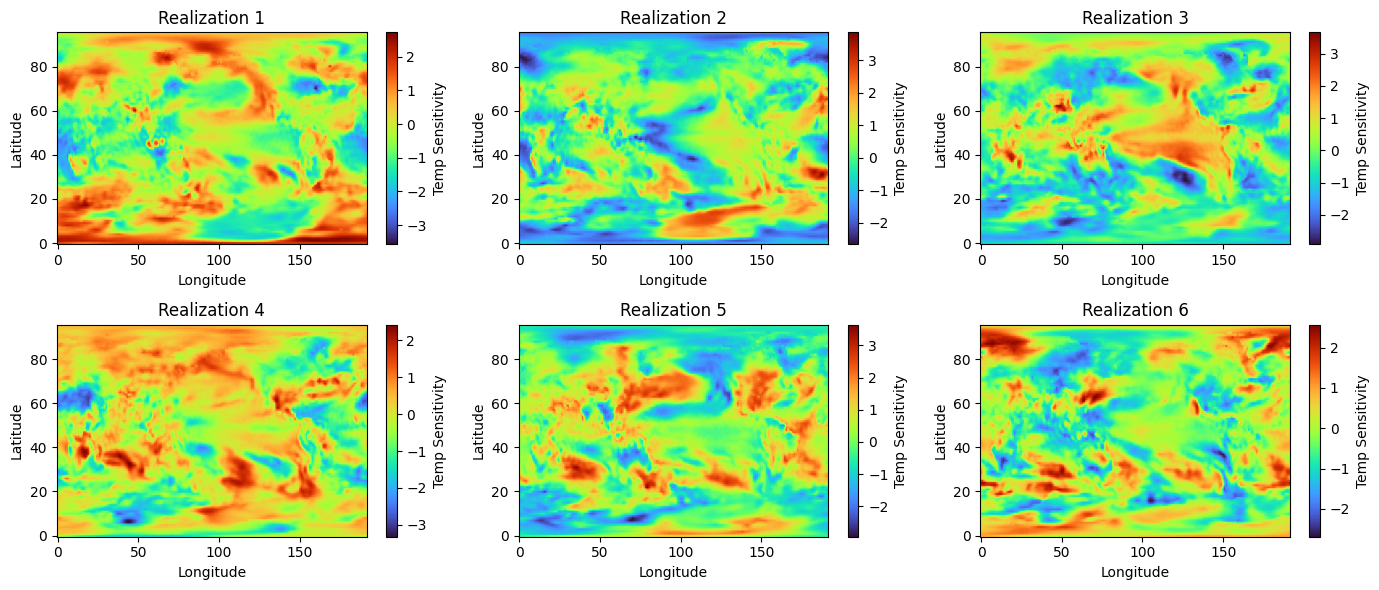

In [6]:
# plot 6 realizations of normalized temp sensitivity
plt.figure(figsize=(14, 6))
for i in range(6):
	plt.subplot(2, 3, i + 1)
	plt.imshow(mpi_temp_sens_norm[i, :, :], cmap="turbo", aspect="auto", origin="lower")
	plt.colorbar(label="Temp Sensitivity")
	plt.title(f"Realization {i + 1}")
	plt.xlabel("Longitude")
	plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [7]:
## saving the normalized slopes. uncomment to save.
# with h5py.File('../data/mpi_temp_sens_fields.h5', 'w') as f:
#     f.create_dataset('clim_fields_norm', data=mpi_temp_sens_norm)

### EC-Earth3 

This is the European Community Earth System Model. We download annual average `tas` (surface temperature) from this model, run at the ssp245 (medium) scenario for 86 years (2015-2100). The model is at a roughly 80 km resolution, resulting in a $512 \times 256$ grid. 

This model is in ClimateSet with 97 ensemble members, although is not found on their HuggingFace: https://huggingface.co/datasets/climateset/climateset/tree/main/outputs. 

The data can also be downloaded off of the Google Cloud Services CMIP6 archive, which is what we do here: https://console.cloud.google.com/marketplace/product/noaa-public/cmip6

Only 72 members have a full 86 year run from 2015-2100, so we use these rather than the full 97. We once again calculate normalized temperature sensitivity. 

In [8]:
url_catalog = "https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv"
df_catalog = pd.read_csv(url_catalog)

In [9]:
df = df_catalog[
	(df_catalog["variable_id"] == "tas")  # surface temp
	& (df_catalog["table_id"] == "Amon")  # monthly data
	& (df_catalog["grid_label"] == "gr")  # regular grid
	& (df_catalog["experiment_id"] == "ssp245")  # medium scenario
	& (df_catalog["source_id"] == "EC-Earth3")  # climate model
	& (df_catalog["member_id"].str.contains("f1"))  # members with full 86 yr run
]
df["member_num"] = (
	df["member_id"].str.extract(r"r(\d+)").astype(int)
)  # extract numerical member ids

display(df.sort_values("member_num").head())

print(len(df), "\n", sorted(np.array(df["member_num"]).tolist()))

C:\Users\anton\AppData\Local\Temp\ipykernel_10868\4256153641.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['member_num'] = df['member_id'].str.extract(r'r(\d+)').astype(int) # extract numerical member ids


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,member_num
425674,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp245,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200310,1
501505,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp245,r2i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20201215,2
439182,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp245,r4i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200425,4
411413,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp245,r6i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200201,6
501680,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp245,r7i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20201217,7


72 
 [1, 2, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]


In [10]:
def process_ensemble_members(
	df,
	n_members=10,
	output_file="../data/EC_Earth3_r1-r72_f1_ssp245_tas_80km_mon_2015-2100.nc",
	verbose=True,
):
	"""
	Processes the first n_members from the filtered EC-Earth3 DataFrame,
	computes annual mean for each, and saves the combined result as a NetCDF.
	Only members with matching shapes are included.
	"""
	annual_means = []
	member_ids = []
	expected_shape = None
	print(f"Processing up to {n_members} members...")
	for idx, row in df.sort_values("member_num").head(n_members).iterrows():
		if verbose:
			print(f"Processing member {row['member_id']}")
		ds = xr.open_zarr(row["zstore"], consolidated=True)
		tas = ds["tas"]
		n_years = tas.shape[0] // 12
		annual_mean = tas.values.reshape(n_years, 12, *tas.shape[1:]).mean(axis=1)
		if verbose:
			print(f"Shape for {row['member_id']}: {annual_mean.shape}")
		if expected_shape is None:
			expected_shape = annual_mean.shape
		if annual_mean.shape == expected_shape:
			annual_means.append(annual_mean)
			member_ids.append(row["member_id"])
		else:
			if verbose:
				print(
					f"Skipping {row['member_id']} due to shape mismatch: {annual_mean.shape} != {expected_shape}"
				)
	if len(annual_means) == 0:
		if verbose:
			print("No members with matching shapes found.")
		return
	annual_means = np.stack(annual_means, axis=0)
	out_ds = xr.Dataset(
		{"tas_annual_mean": (["member", "year", "lat", "lon"], annual_means)},
		coords={
			"member": member_ids,
			"year": np.arange(expected_shape[0]),
			"lat": tas["lat"].values,
			"lon": tas["lon"].values,
		},
	)
	out_ds.to_netcdf(output_file)
	print(f"Saved {output_file}")

In [11]:
## uncomment to redownload the ensemble yourself (not necessary)
# process_ensemble_members(df, n_members=len(df), verbose=False)

In [12]:
ec3_file_path = "../data/EC_Earth3_r1-r72_f1_ssp245_tas_80km_mon_2015-2100.nc"
ec3_df = netCDF4.Dataset(ec3_file_path)

print("Variables: ", ec3_df.variables.keys())
print("Dimensions of tas: ", ec3_df.variables["tas_annual_mean"].dimensions)

ec3_tas = ec3_df.variables["tas_annual_mean"][:] - 273.15
print("Shape of tas: ", ec3_tas.shape)

Variables:  dict_keys(['tas_annual_mean', 'member', 'year', 'lat', 'lon'])
Dimensions of tas:  ('member', 'year', 'lat', 'lon')
Shape of tas:  (72, 86, 256, 512)


In [13]:
ec3_global_means = ec3_tas.mean(axis=(2, 3), keepdims=False)
print("Shape of global means: ", ec3_global_means.shape)
print(
	"Global means (first member, first and last values): ",
	ec3_global_means[0, 0],
	ec3_global_means[0, -1],
)

Shape of global means:  (72, 86)
Global means (first member, first and last values):  6.966941708489344 9.60954717746938


In [14]:
ec3_temp_sens = LPS_slopes(ec3_tas, ec3_global_means)
ec3_temp_sens_norm = (ec3_temp_sens - ec3_temp_sens.mean(axis=0)) / ec3_temp_sens.std(
	axis=0
)

# clean memory
del ec3_tas

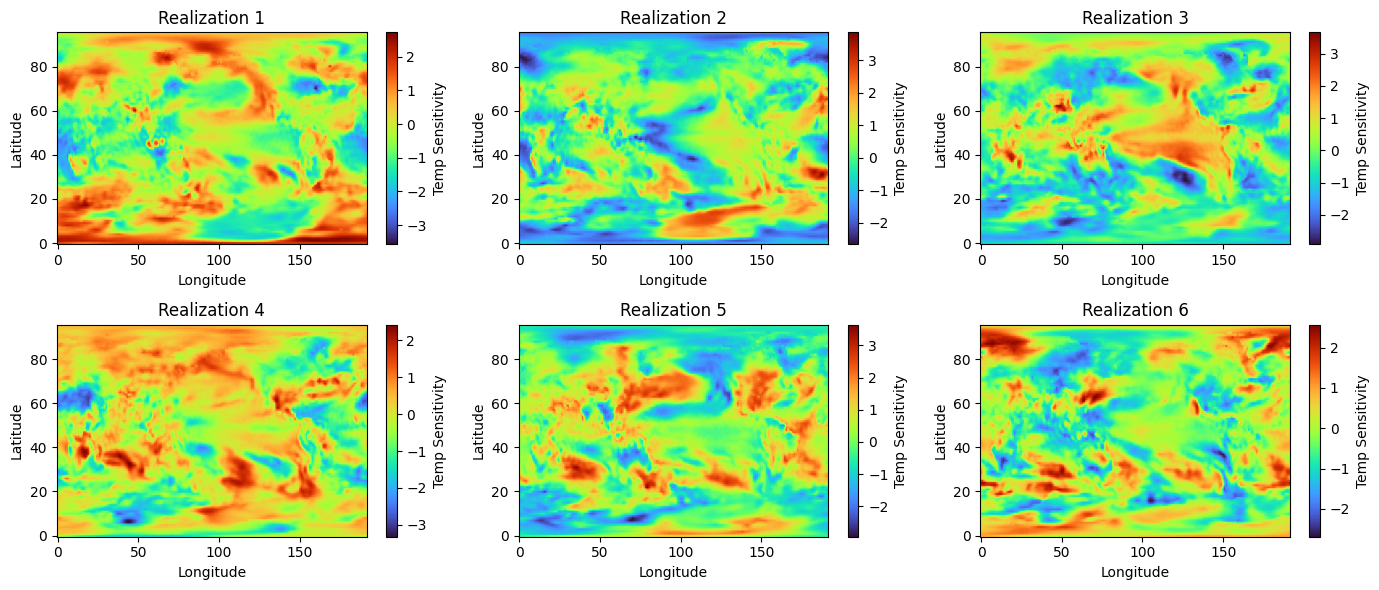

In [15]:
# plot 6 realizations of normalized temp sensitivity
plt.figure(figsize=(14, 6))
for i in range(6):
	plt.subplot(2, 3, i + 1)
	plt.imshow(mpi_temp_sens_norm[i, :, :], cmap="turbo", aspect="auto", origin="lower")
	plt.colorbar(label="Temp Sensitivity")
	plt.title(f"Realization {i + 1}")
	plt.xlabel("Longitude")
	plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [ ]:
# saving the normalized slopes. uncomment to save.
# with h5py.File('../data/ec3_temp_sens_fields.h5', 'w') as f:
#     f.create_dataset('clim_fields_norm', data=ec3_temp_sens_norm)

### CESM

There is no data processing to be done, as this data is taken directly from here: https://github.com/NCAR/LatticeKrig/tree/master/Datasets/LENNS

This is the NCAR Community Earth System Model, at roughly  $1^\circ$ (~200 km) resolution, resulting in a $288 \times 192$ grid. The data already contains normalized temperature sensitivity fields. 